In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
!nvidia-smi

Sun Aug 18 18:35:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
os.chdir('/kaggle/input/test-autoannotation/')

# **Installs**

In [4]:
!pip install transformers
# !pip install chromadb
!pip install sentence-transformers
!pip install datasets
!pip install timm
!pip install flash_attn
!pip install huggingface_hub
!pip install rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=186973264 sha256=a317a6656be86fa5f583be039c38408258633a21c9de5d5623e11486d6a5541c
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [5]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 4.7 MB/s eta 0:00:00:00:01


# **Imports**

In [6]:
import requests
import zipfile
from pathlib import Path
import logging
import yaml
import json
import datetime

from PIL import Image
import numpy as np
import torch
from tqdm import tqdm
from pycocotools.coco import COCO

from transformers import (
    CLIPProcessor,
    CLIPModel,
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer
)

# import chromadb
# from chromadb.utils import embedding_functions

# Logging setup (optional)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

2024-08-18 18:37:24.158520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 18:37:24.158643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 18:37:24.274009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
image_dir = Path("/kaggle/input/test-autoannotation/data/data/test")
# augmented_image_dir = Path("/content/drive/My Drive/AutoAnnotationDatasets/test/")
persist_directory = Path("/kaggle/working/image_embeddings_file/")

# Create directories if they don't exist
# augmented_image_dir.mkdir(parents=True, exist_ok=True)
persist_directory.mkdir(parents=True, exist_ok=True)

# **Data Ingestion**

In [8]:
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
# augmented_image_files = [f for f in os.listdir(augmented_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
all_image_files = image_files 

# Load images and convert to RGB if necessary
images = []
for image_file in all_image_files:
    if image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
    else:
        image_path = os.path.join(augmented_image_dir, image_file)
    image = Image.open(image_path).convert('RGB')
    images.append(image)


# **Model Loading**

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoProcessor

# Load model directly
# from transformers import AutoModelForCausalLM
# model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

# model_id = 'microsoft/Florence-2-large'
# model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
# processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# model_id = 'microsoft/Florence-2-base'
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='float16').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
model.eval()

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

# **Preprocessing**

In [11]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Define preprocessing function
def preprocess_and_save_image(image, save_dir, image_name, target_size=(224, 224)):
    """
    Preprocess the image by resizing, normalizing, and converting it to a tensor.
    Then save the preprocessed image.

    Args:
        image: A PIL Image object.
        save_dir: Directory to save the preprocessed image.
        image_name: Name to save the image as.
        target_size: A tuple specifying the target size for resizing (width, height).
    """
    preprocess_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),  # Convert PIL Image to Tensor and normalize to [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match the model's expected input
    ])
    
    # Apply preprocessing to the image
    preprocessed_image = preprocess_transform(image)
    
    # Convert tensor back to a PIL Image for saving
    unnormalize_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    
    # Unnormalize and convert the tensor back to PIL Image
    preprocessed_image_pil = unnormalize_transform(preprocessed_image)
    
    # Save the preprocessed image
    save_path = os.path.join(save_dir, image_name)
    preprocessed_image_pil.save(save_path)


In [12]:
# Directory to save preprocessed images
save_dir = "/kaggle/working/preprocessed_images/"
os.makedirs(save_dir, exist_ok=True)

# Process and save images
for image_file in all_image_files:
    if image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
    else:
        image_path = os.path.join(augmented_image_dir, image_file)

    image = Image.open(image_path).convert('RGB')
    preprocess_and_save_image(image, save_dir, image_file)

# **Annotattion generator**

In [13]:
# Helper function to run the model
def annotation_processor(task_prompt, model, processor, image):
    inputs = processor(text=[task_prompt], images=[image], return_tensors="pt", padding=True)
    
    # Move tensors to CUDA
    inputs["input_ids"] = inputs["input_ids"].cuda().to(torch.long)  # Ensure input_ids are LongTensor
    inputs["pixel_values"] = inputs["pixel_values"].cuda().to(torch.float16)

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],  # Already on CUDA and of correct type
        pixel_values=inputs["pixel_values"],  # Already on CUDA
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    
    return parsed_answer

In [14]:
import os
import datetime
from PIL import Image
image_dir=save_dir
def generate_coco_annotations(image_dir, model, processor):
    """
    Generates annotations in COCO format for images in the given directories.

    Args:
        image_dir: Path to the directory containing original images.
        model: The Florence-2-base model for generating captions and object detections.
        processor: The processor associated with the Florence-2-base model.

    Returns:
        A dictionary representing the COCO annotations.
    """

    # Initialize COCO data structures
    coco_annotations = {
        "info": {
            "description": "Auto-generated COCO annotations",
            "url": "",
            "version": "1.0",
            "year": datetime.datetime.now().year,
            "contributor": "Himanko Boruah",
            "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        "licenses": [],
        "images": [],
        "annotations": [],
        "captions": [],
        "categories": []
    }

    # Define task prompts
    task_prompts = ['<CAPTION>', '<DETAILED_CAPTION>', '<MORE_DETAILED_CAPTION>', '<OD>']

    # Process images
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    image_id = 1
    annotation_id = 1
    caption_id = annotation_id

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        
        
#         caption = '<CAPTION>'
#         date_captured = '<DETAILED_CAPTION>'

        # Add image information to COCO
        coco_annotations["images"].append({
            "id": image_id,
            "width": image.width,
            "height": image.height,
            "file_name": image_file,
            "license": 'Apache License 2.0',
            "flickr_url": None,
            "coco_url": None,
            "date_captured": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })
        
        
#         results = {}
#         for task_prompt in task_prompts:
#             results[task_prompt] = annotation_processor(task_prompt, model, processor, image)
        
        # Generate annotations for each task prompt
        results = []
        for task_prompt in task_prompts:
            results = annotation_processor(task_prompt, model, processor, image)

            if task_prompt == '<OD>':
                bboxes = results['<OD>']['bboxes']
                labels = results['<OD>']['labels']

                for bbox, label in zip(bboxes, labels):
                    # Check if the label exists in categories
                    category_id = None
                    for category in coco_annotations['categories']:
                        if category['name'] == label:
                            category_id = category['id']
                            break

                    # If the label is not in categories, add it
                    if category_id is None:
                        category_id = len(coco_annotations['categories']) + 1
                        coco_annotations['categories'].append({
                            "id": category_id,
                            "name": label,
                            "supercategory": "object"
                        })

                    # Add annotation for the object
                    coco_annotations["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": category_id,
                        "segmentation": [],  # Add segmentation if available
                        "area": bbox[2] * bbox[3],
                        "bbox": bbox,
                        "iscrowd": 0
                    })
                    annotation_id += 1
                    
            # Process captions
            for task_prompt in ['<CAPTION>', '<DETAILED_CAPTION>', '<MORE_DETAILED_CAPTION>']:
                if task_prompt in results:
                    caption_data = {
                        "id": caption_id,
                        "image_id": image_id,
                        "caption": results[task_prompt]
                    }
                    coco_annotations["captions"].append(caption_data)
                    caption_id += 1

        image_id += 1

    return coco_annotations


# Generate COCO annotations
coco_annotations = generate_coco_annotations(image_dir, model, processor)
# # Print or save the COCO annotations as needed
# print(json.dumps(coco_annotations, indent=4))

# **Save and load the generated file**

In [15]:
# Save the COCO annotations to a file
coco_annotations_file = '/kaggle/working/image_embeddings_file/coco_annotations.json'
with open(coco_annotations_file, 'w') as f:
    json.dump(coco_annotations, f, indent=4)

print(f"COCO annotations saved to {coco_annotations_file}")

COCO annotations saved to /kaggle/working/image_embeddings_file/coco_annotations.json


In [16]:
# # Load the COCO annotations from the file
# coco_annotations_file = '/kaggle/working/image_embeddings_file/coco_annotations.json'
# with open(coco_annotations_file, 'r') as f:
#     loaded_coco_annotations = json.load(f)

# # Print the loaded COCO annotations
# print(json.dumps(loaded_coco_annotations, indent=4))

# print(f"COCO annotations loaded from {coco_annotations_file}")

In [17]:
# # Load the COCO annotations from the file
# coco_ground_truth_file = '/kaggle/input/test-autoannotation/test- autoannotation/captions_val2017.json'
# with open(coco_ground_truth_file, 'r') as f:
#     loaded_coco_ground_truth = json.load(f)

# # Print the loaded COCO annotations
# print(json.dumps(loaded_coco_ground_truth, indent=4))

# print(f"COCO annotations loaded from {coco_ground_truth_file}")

# **Convert the annotation into YOLO**

In [18]:
import os
import json

def generate_yolo_annotations(image_dir, coco_annotations_file, yolo_annotations_dir):
    """
    Generates YOLO format annotations from COCO annotations.

    Args:
        image_dir: Path to the directory containing original images.
        coco_annotations_file: Path to the COCO annotations JSON file.
        yolo_annotations_dir: Directory where YOLO format annotation files will be saved.
    """
    # Load COCO annotations
    with open(coco_annotations_file, 'r') as f:
        coco_annotations = json.load(f)

    # Create output directory if it doesn't exist
    os.makedirs(yolo_annotations_dir, exist_ok=True)

    # Mapping from COCO category IDs to YOLO class IDs
    category_id_to_class_id = {cat['id']: idx for idx, cat in enumerate(coco_annotations['categories'])}

    # Prepare to process each image
    for image in coco_annotations['images']:
        image_id = image['id']
        image_file_name = image['file_name']
        image_width = 224
        image_height = 224

        # Create YOLO annotation file
        yolo_annotation_file = os.path.join(yolo_annotations_dir, os.path.splitext(image_file_name)[0] + '.txt')
        with open(yolo_annotation_file, 'w') as f:
            for annotation in coco_annotations['annotations']:
                if annotation['image_id'] == image_id:
                    category_id = annotation['category_id']
                    class_id = category_id_to_class_id.get(category_id, None)

                    if class_id is not None:
                        bbox = annotation['bbox']
                        # x_min, y_min, width, height = bbox
                        xmin, ymin, xmax, ymax = bbox

                        # Calculate normalized center coordinates
                        x_center = (xmin + xmax) / (2 * image_width)
                        y_center = (ymin + ymax) / (2 * image_height)

                        # Calculate normalized width and height
                        width = (xmax - xmin) / image_width
                        height = (ymax - ymin) / image_height
                        
                        # # Convert bounding box to YOLO format
                        # x_center = (x_min + width / 2) / image_width
                        # y_center = (y_min + height / 2) / image_height
                        # width = width / image_width
                        # height = height / image_height

                        # Write the YOLO annotation line
                        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

        print(f"YOLO annotations saved to {yolo_annotation_file}")


In [19]:
# Example usage
image_dir = '/kaggle/input/test-autoannotation/data/data/test'
coco_annotations_file = '/kaggle/working/image_embeddings_file/coco_annotations.json'
yolo_annotations_dir = '/kaggle/working/yolo_annotations'
os.makedirs(yolo_annotations_dir, exist_ok=True)
generate_yolo_annotations(image_dir, coco_annotations_file, yolo_annotations_dir)

# # Example usage
# train_image_dir = '/content/drive/My Drive/AutoAnnotationDatasets/data_coco/train/'
# val_image_dir = '/content/drive/My Drive/AutoAnnotationDatasets/data_coco/val/'
# test_image_dir = '/content/drive/My Drive/AutoAnnotationDatasets/data_coco/test/'

# train_coco_annotations_file = '/content/drive/My Drive/AutoAnnotationDatasets/data_annotation_coco/train_coco_annotations.json'
# val_coco_annotations_file = '/content/drive/My Drive/AutoAnnotationDatasets/data_annotation_coco/val_coco_annotations.json'
# test_coco_annotations_file = '/content/drive/My Drive/AutoAnnotationDatasets/data_annotation_coco/test_coco_annotations.json'
# yolo_annotations_dir_train = '/content/drive/My Drive/AutoAnnotationDatasets/yolo_annotation/train'
# yolo_annotations_dir_val = '/content/drive/My Drive/AutoAnnotationDatasets/yolo_annotation/validation'
# yolo_annotations_dir_test = '/content/drive/My Drive/AutoAnnotationDatasets/yolo_annotation/test'
# # Create the output directory if it doesn't exist
# os.makedirs(yolo_annotations_dir_train, exist_ok=True)
# os.makedirs(yolo_annotations_dir_val, exist_ok=True)

YOLO annotations saved to /kaggle/working/yolo_annotations/000000008844.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000005992.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000006894.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000000785.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000005193.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000009891.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000001296.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000007784.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000004495.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000007795.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000003661.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000007977.txt
YOLO annotations saved to /kaggle/working/yolo_annotations/000000003553.txt
YOLO annotat

# **Visualization**

In [ ]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()

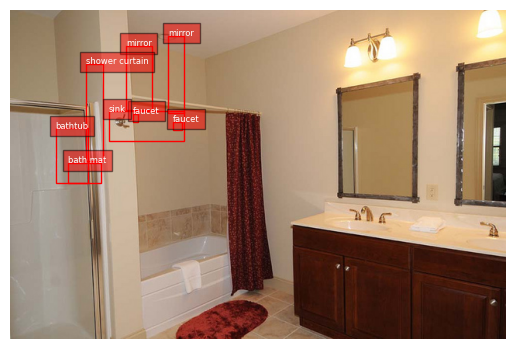

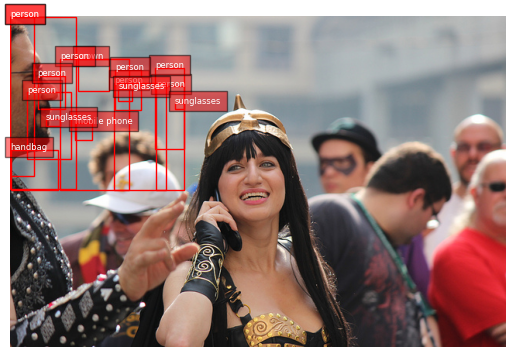

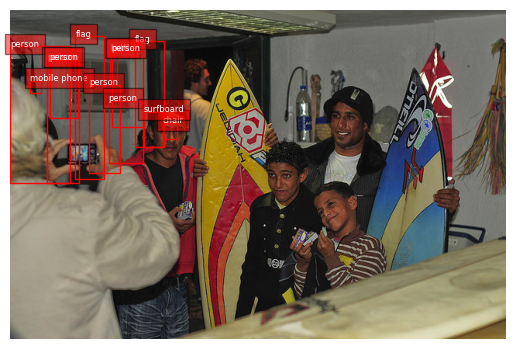

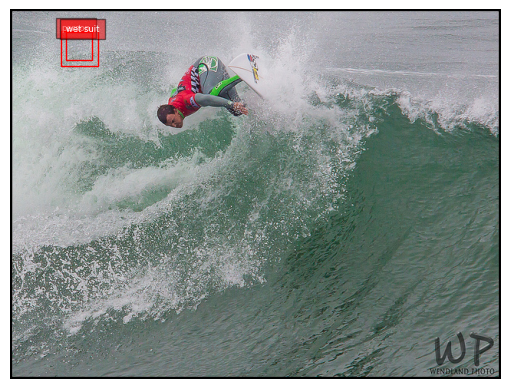

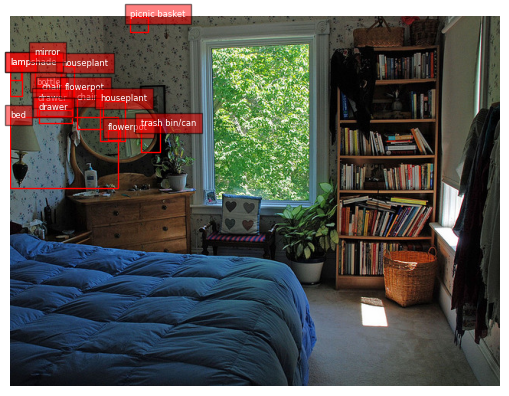

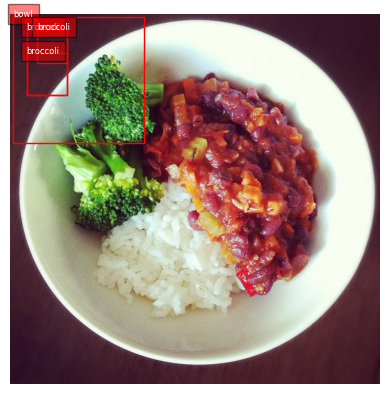

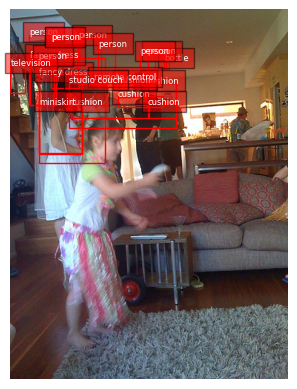

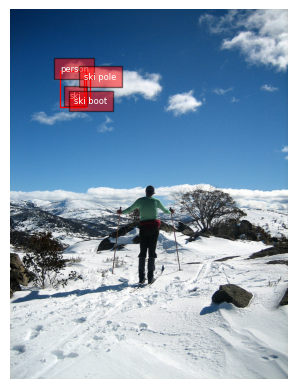

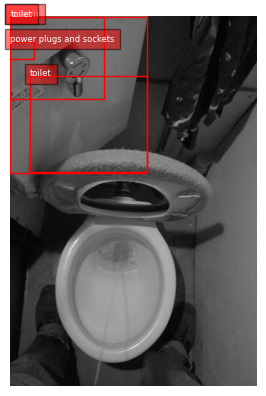

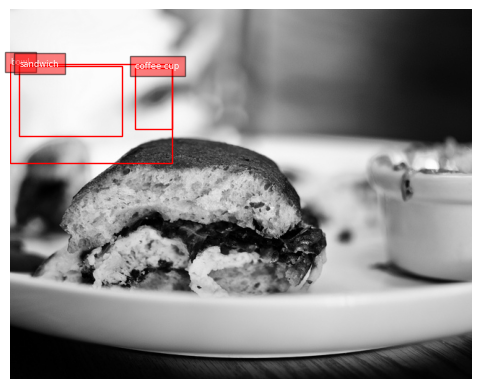

In [25]:
import os
import random
import json
import datetime
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, bboxes, labels, save_path):
    """
    Plots bounding boxes on an image.
    """
    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox, label in zip(bboxes, labels):
        x1, y1, x2, y2 = bbox
        width, height = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=6, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
     # Save the plot as an image file  
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

def visualize_random_images(image_dir, coco_annotations, num_images=5):
    """
    Visualizes random images with their corresponding bounding boxes and labels.
    """
    random_images = random.sample(coco_annotations["images"], num_images)

    for image_info in random_images:
        image_path = os.path.join(image_dir, image_info["file_name"])
        image = Image.open(image_path).convert('RGB')
        
        annotations = [ann for ann in coco_annotations["annotations"] if ann["image_id"] == image_info["id"]]
        bboxes = [ann["bbox"] for ann in annotations]
        labels = [ann["category_id"] for ann in annotations]

        # Get label names
        label_names = []
        for label_id in labels:
            category = next(cat for cat in coco_annotations["categories"] if cat["id"] == label_id)
            label_names.append(category["name"])

        plot_bbox(image, bboxes, label_names, save_path)

save_path = '/kaggle/working/'
os.makedirs(save_path, exist_ok=True)


# Visualize random 5 images
visualize_random_images(image_dir, coco_annotations, num_images=10)
